In [ ]:
import requests
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from pprint import pprint
from bs4 import BeautifulSoup

In [2]:
YELP_TOKEN = ""

In [3]:
#Fetch JSON for 50 restaurants in Toronto area
r = requests.get("https://api.yelp.com/v3/businesses/search?location=Toronto&limit=50", headers={"Authorization": "Bearer %s" % YELP_TOKEN})

In [13]:
#requests.get(reviews['reviews'][0]['url']).content

In [ ]:
#Scrape the content from the business URLs obtained from the business API. Iterating these URLs using "&start=%s" to fetch 
#reviews from multiple pages. The limit for the same has been set to 80 along with 50 for businesses, 
#fetching 100 reviews per restaurant for 50 restaurants. This gives us a total of 5000 reviews.
review_labels = []
for business in r.json()['businesses']:
    start_count = 0
    reviews_raw = BeautifulSoup(requests.get(business['url']+'&start=%s' %start_count).content, 'html.parser').find_all(itemprop="review")
    reviews_count = len(reviews_raw)
    print(business['name'] + '\n\n')
    while reviews_count != 0 and start_count <= 80 :
        print('reviews_count - %s \n' %reviews_count)
        print('start_count - %s \n\n' %start_count)
        for rev in reviews_raw:
            rev_desc = rev.get_text().strip('\n')
            rev_rating = rev.find(itemprop="ratingValue")['content']
            review_labels.append((rev_desc,rev_rating))
            print((rev_desc, rev_rating))
        start_count += 20
        reviews_raw = BeautifulSoup(requests.get(business['url']+'&start=%s' %start_count).content, 'html.parser').find_all(itemprop="review")
review_labels

In [5]:
len(review_labels)

5000

In [ ]:
review_features = [(x, 'positive' if float(y) > 3 else 'negative') for (x, y) in review_labels]

In [7]:
reviews_df = pd.DataFrame(review_features, columns =['Review', 'Rating'])
reviews_df

,Review,Rating
0,"I'm a thai foody, so I had to bring my colleag...",positive
1,Super packed on a Monday evening. Grateful for...,positive
2,Food 4/5\nService 5/5\nAmbience 4/5\nCleanline...,positive
3,WOW!! Completely understand why this restauran...,positive
4,Came here on a Monday at lunch and it was real...,positive
...,...,...
4995,"This place come with a lot of HYPE, and I'm ha...",positive
4996,I really wanted to like this place. I have att...,negative
4997,Came here on a Sunday for brunch with my boyfr...,positive
4998,My friend and I purposely came here for brunch...,positive


In [8]:
reviews_positive = reviews_df.loc[reviews_df['Rating']=='positive']
reviews_negative = reviews_df.loc[reviews_df['Rating']=='negative']

In [9]:
reviews_positive.shape

(4205, 2)

In [10]:
reviews_negative.shape

(795, 2)

In [11]:
reviews_positive.shape[0]

4205

Random over-sampling:
negative    4205
positive    4205
Name: Rating, dtype: int64


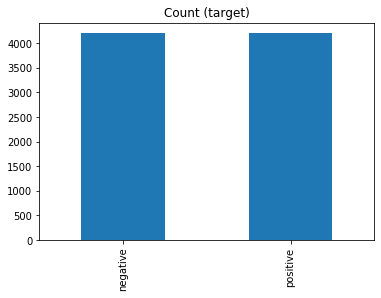

In [12]:
#Oversampling negative reviews data to balance the dataset
reviews_negative_over = reviews_negative.sample(reviews_positive.shape[0], replace=True)
reviews_over = pd.concat([reviews_positive, reviews_negative_over], axis=0, ignore_index=False)

print('Random over-sampling:')
print(reviews_over.Rating.value_counts())

reviews_over.Rating.value_counts().plot(kind='bar', title='Count (target)');

In [15]:
type(reviews_over)

pandas.core.frame.DataFrame

In [16]:
#Resetting indices to remove duplicated indices of negative reviews
reviews_over.index = range(reviews_over.shape[0])

In [17]:
#Shuffling the dataset
#Could also use .sample for this -> reviews_train_over.sample(reviews_train_over.shape[0], replace=False)
reviews_over = reviews_over.reindex(np.random.permutation(reviews_over.index), axis=0)
reviews_over

,Review,Rating
2766,It was worth the trip down to Kensington. My a...,positive
3364,Food: 5\nPrice: $\nInterior: 4\n\n\nWe had lun...,positive
7391,Great late night bar with good late night food...,negative
425,This review is for the charcuterie class and t...,positive
5708,So here's the thing... the Ripley's Aquariums ...,negative
...,...,...
2856,I've been to Tinuno multiple times and they ne...,positive
2852,About last night... What a great Filipino Kama...,positive
1999,Had to check out this place after seeing all t...,positive
7667,This place is conveniently located a couple bl...,negative


In [18]:
#No duplicated indices
reviews_over[reviews_over.index.duplicated()]

,Review,Rating


In [19]:
#Using lists to balance dataset without oversampling. Ignore this...
"""#Separating positive and negative reviews
positive_rev = []
negative_rev = []
for review in review_features:
    positive_rev.append(review) if review[1] == 'positive' else negative_rev.append(review)
print(len(positive_rev))
print(len(negative_rev))

#Balancing positive and negative reviews
positive_len = len(positive_rev)
negative_len = len(negative_rev)
while(positive_len > negative_len):
    positive_rev.pop(random.randrange(len(positive_rev)))
    positive_len -= 1
print(len(positive_rev))
print(len(negative_rev))

review_features_balanced = positive_rev + negative_rev
review_features_balanced"""

"#Separating positive and negative reviews\npositive_rev = []\nnegative_rev = []\nfor review in review_features:\n    positive_rev.append(review) if review[1] == 'positive' else negative_rev.append(review)\nprint(len(positive_rev))\nprint(len(negative_rev))\n\n#Balancing positive and negative reviews\npositive_len = len(positive_rev)\nnegative_len = len(negative_rev)\nwhile(positive_len > negative_len):\n    positive_rev.pop(random.randrange(len(positive_rev)))\n    positive_len -= 1\nprint(len(positive_rev))\nprint(len(negative_rev))\n\nreview_features_balanced = positive_rev + negative_rev\nreview_features_balanced"

In [23]:
pd.set_option('display.max_colwidth', -1)
file = open("data.json", "w", encoding="utf-8")
file.write(reviews_over.to_json(orient = "records"))
file.close()

In [ ]:
#Splitting review description in an array
reviews_over.Review = reviews_over.Review.apply(lambda x: x.split(' '))
reviews_over

In [122]:
review_features_balanced_df = reviews_over

In [117]:
len(review_features_balanced_df)

8406

In [123]:
review_features_balanced = list(review_features_balanced_df.itertuples(index=False))

In [124]:
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

training_docs = []
test_docs = []
training_docs = review_features_balanced[:5500]
test_docs = review_features_balanced[5500:]

print("Training: %d, Testing: %d" % (len(training_docs), len(test_docs)))

sentim_analyzer = SentimentAnalyzer()

Training: 5500, Testing: 2906


In [ ]:
all_words_neg = sentim_analyzer.all_words([nltk.sentiment.util.mark_negation(doc) for doc in training_docs])

In [126]:
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(nltk.sentiment.util.extract_unigram_feats, unigrams=unigram_feats)

In [127]:
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [130]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.7887130075705437
F-measure [negative]: 0.7681268882175226
F-measure [positive]: 0.8059418457648546
Precision [negative]: 0.8546218487394958
Precision [positive]: 0.743006993006993
Recall [negative]: 0.6975308641975309
Recall [positive]: 0.880524861878453


<BarContainer object of 5 artists>

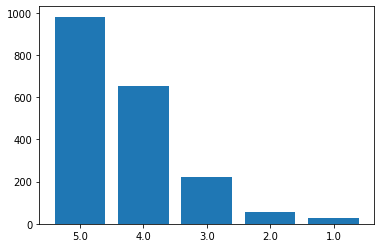

In [92]:
from collections import defaultdict

c = defaultdict(int)
for x in review_labels:
    c[x[1]] += 1

plt.bar(c.keys(), c.values())